# 👀 Multilayer perceptron (MLP)

In this notebook, we'll walk through the steps required to train your own multilayer perceptron on the CIFAR dataset

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, optimizers, utils, datasets

%cd /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks

from utils import display

/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks


## 0. Parameters <a name="parameters"></a>

In [5]:
NUM_CLASSES = 10

## 1. Prepare the Data <a name="prepare"></a>

In [6]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [7]:
# Dividing by 255 will put all the pixels in the range [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Transforms the strings 'dog', 'cat', etc. into one-hot vectors where each vector has length num-classes and 1 where the class is and 0 everywhere else
y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

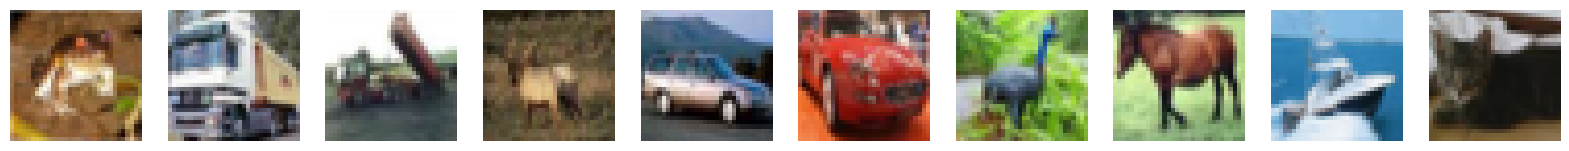

x_train shape: (50000, 32, 32, 3)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
y_train shape: (50000, 10)


In [8]:
display(x_train[:10])
print(f'x_train shape: {x_train.shape}')
print(y_train[:10])
print(f'y_train shape: {y_train.shape}')

## 2. Build the model <a name="build"></a>

### Mathematical Overview

The *Multi-Layer Perceptron* (MLP) begins with the *perceptron*, the smallest computational unit. 

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/Perceptron.png' alt='Perceptron' width='500'>
</div>

We can see the inspiration with a biological neuron. The structures is as follows: Let $X$ be the data and $\mathbf{x} \in X$ be a datum. Then, let $\mathbf{w}$ be the *weights* of the neuron and $b$ be the *bias* of the neuron. Then, the computation is carried out as $z = \mathbf{x}\mathbf{w}^T + b$. From there, it is fed into an activation function $g(z)$ to get the output, a scaler $a$. 

We can then stack multiple neurons and add layers of stacked neurons to get a *Deep Neural Network*, or our MLP: 

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/Deep_Neural_Network.png' alt='DNN' width='500'>
</div>

The mathematics are as follows: Let $*^{[l]}$ be the $l$-th layer and $*^{(i)}$ be the $i$-th data instance. Each layer has $n^{[l]}$ neurons. We can use vectorized notation to help us out. We define $A^{[l]}$ to be output of the $l$-th layer over all data instances. This means that $A^{[0]}=X$. Let $W^{[l]}$ be the weights of the $l$-th layer and $b^{[l]}$ be the matrix of all biases of that layer. Note that the number of columns of this matrix is the number of neurons from the previous layer, as the information layer $l$ will recieve is the outputs of the $(l-1)$-th layer and $b^{[l]}$ is an $(n^{[l]},1)$ matrix. Then, our computation looks like:

$$ A^{[0]} = X $$
$$ A^{[1]} = g(W^{[1]}X+b^{[1]}) $$
$$ A^{[2]} = g(W^{[2]}A^{[1]}+b^{[2]}) $$
$$ \hat{Y} = A^{[L]}=g(W^{[L]}A^{[l-1]}+b^{[L]}) $$

Succinctly, we can write the output of layer $l$ as:

$$ f^{[l]}_{(W^{[l]}, b^{[l]})} = g(W^{[l]}f^{[l-1]}_{(W^{[l-1]}, b^{[l-1]})}+b^{[L]}) $$

Then, our entire neural network can be written as: 

$$ \hat{Y} := F_{(W,b)}(X) = f^{[L]}_{(W^{[L]}, b^{[L]})} \circ f^{[1]}_{(W^{[1]}, b^{[1]})}(X) $$

Now, our goal is to train the neural network to *do something*, so we need a function to determine how well it is doing. As in, we feed in our $X$ and recieve $\hat{Y}$. We then define $\mathcal{L}$ to be the *Loss* function, which will be a function of the model parameters $\Theta = (W,b)$. Now, depending on exactly what we are doing (classification, outputting a real-numbered value, etc.), it will change. We then define the *Cost* function as simply the loss over the batch. Mathematically, this gives us:

$$ J(\Theta) = \frac{1}{|\mathcal{B}|} \sum_{i \in \{1, ..., |\mathcal{B}| \}} \mathcal{L}_{\Theta}(Y^{(i)}, \hat{Y}^{(i)})$$

We note that often we say that the cost is just the loss function, as in, the cost is just the sum over the loss, so it isn't too important to have unique functions here. We will adopt this from now on, simply saying that the loss is the sum over the loss. We might refer to a single loss (for a single datum) as $l$, but we will make it obvious when we do so. We then need to update our weights and biases on each iteration so the model is learning. We do this through *Gradient Descent*:

$$ \Theta_{k+1} = \Theta_{k} - \alpha_{k} \nabla_{\Theta_{k}} J(\Theta_{k}) $$ 

As in, we have our *Learning Rate* $\alpha$ that controls how big a step we make and we find the gradient of each parameter, or how it contributes to the cost/loss function, and move that parameters current value by the contribution to the cost/loss times the step size. Now, the $k$ is the iteration, and we can modify our step size during training. Perhaps in the beginning, when we are far away from the minimum, we take larger steps, but as we get closer, we take smaller one to avoid overshooting the bottom. 

This is the general, albeit brief, mathematical overview of the MLP.

In [8]:
input_layer = layers.Input((32, 32, 3)) # We need to give the model the input size, which is (Height, Width, 3), where the 3 is the three channels

x = layers.Flatten()(input_layer) # Flatten into a vector
x = layers.Dense(200, activation="relu")(x) # Desne layer
x = layers.Dense(150, activation="relu")(x)

output_layer = layers.Dense(NUM_CLASSES, activation="softmax")(x) # Maps the model output to just num-classes outputs

model = models.Model(input_layer, output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 200)               614600    
                                                                 
 dense_1 (Dense)             (None, 150)               30150     
                                                                 
 dense_2 (Dense)             (None, 10)                1510      
                                                                 
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0
_________________________________________________________________


2023-07-05 14:25:01.750915: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-07-05 14:25:01.750987: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: OPH-M-DF98PS3L
2023-07-05 14:25:01.751000: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: OPH-M-DF98PS3L
2023-07-05 14:25:01.751209: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.125.6
2023-07-05 14:25:01.751260: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.105.17
2023-07-05 14:25:01.751271: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 525.105.17 does not match DSO version 525.125.6 -- cannot find working devices in this configuration
2023-07-05 14:25:01.751630: I tensorflow/core/platform/cpu_feature_guard.cc:19

## 3. Train the model <a name="train"></a>

In [9]:
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

In [10]:
model.fit(x_train, y_train, batch_size=32, epochs=10, shuffle=True)

Epoch 1/10


2023-07-05 14:25:10.367768: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


1563/1563 [==============================] - 3s 2ms/step - loss: 1.8515 - accuracy: 0.3345
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.6577 - accuracy: 0.4086
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.5854 - accuracy: 0.4347
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.5293 - accuracy: 0.4533
Epoch 5/10
1563/1563 [==============================] - 2s 2ms/step - loss: 1.4893 - accuracy: 0.4708
Epoch 6/10
1563/1563 [==============================] - 2s 2ms/step - loss: 1.4571 - accuracy: 0.4801
Epoch 7/10
1563/1563 [==============================] - 2s 2ms/step - loss: 1.4350 - accuracy: 0.4890
Epoch 8/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.4046 - accuracy: 0.5003
Epoch 9/10
1563/1563 [==============================] - 2s 2ms/step - loss: 1.3848 - accuracy: 0.5060
Epoch 10/10
1563/1563 [==============================] - 2s 2ms/step - loss: 1.3646 - accurac

## 4. Evaluation <a name="evaluate"></a>

In [11]:
model.evaluate(x_test, y_test)

  1/313 [..............................] - ETA: 36s - loss: 1.2734 - accuracy: 0.4375

2023-07-05 14:25:40.179040: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.


313/313 [==============================] - 0s 1ms/step - loss: 1.4060 - accuracy: 0.5002


[1.4060139656066895, 0.5001999735832214]

In [12]:
CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

136/313 [============>.................] - ETA: 0s

2023-07-05 14:25:44.575220: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.


313/313 [==============================] - 0s 860us/step


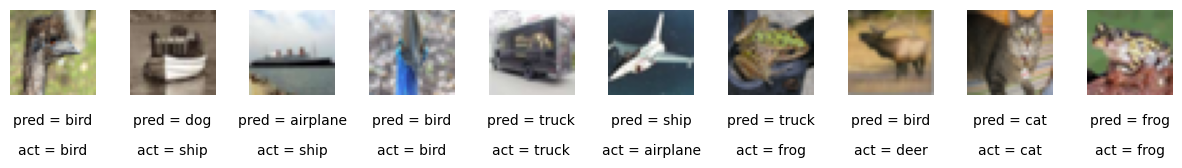

In [13]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)